In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import pandas as pd
import numpy as np
import glob
import re
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [23]:
# with tf.device('/gpu:2'):
#     from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape
#     from keras.models import Model
#     from keras import backend as K

#     input_img = Input(shape=(64, 64,1))  # adapt this if using `channels_first` image data format

#     x = Conv2D(64, (64, 64), activation='relu', padding='same')(input_img)
#     x = Conv2D(1, (64, 64), activation='relu', padding='same')(x)
#     x = Flatten()(x)

#     x = Dense(4096, activation='relu')(x)
#     x = Dense(1024, activation='relu')(x)
#     encoded = Dense(128, activation='relu')(x)

#     x = Dense(1024, activation='relu')(encoded)
#     x = Dense(4096, activation='relu')(x)

#     x = Reshape((64,64,1))(x)
#     x = UpSampling2D((8,8))(x)
#     x = Reshape((64,64,64))(x)
#     x = Conv2D(64, (64, 64), activation='relu', padding='same')(x)
#     decoded = Conv2D(1, (64, 64), activation='sigmoid', padding='same')(x)


#     autoencoder = Model(input_img, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# autoencoder.summary()

In [3]:
def next_batch(num, data):

    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]

    return np.asarray(data_shuffle)

In [4]:
# seq = [str(i).zfill(4) for i in range(1,101)]
# for s in seq:
# for file in glob.glob('GSCdata/*png'):
#     images.append(cv2.imread(file,0))
images = [cv2.imread(file,0) for file in glob.glob('GSCdata/*png')]
names = [re.sub('\.png$', '',os.path.basename(x)) for x in glob.glob('GSCdata/*png')]
images = np.array(images)
print(images.shape)

(14072, 64, 64)


In [5]:

x_train, x_test,names_train,names_test = train_test_split(images,names, test_size=0.2)
print(x_train.shape)
print(x_test.shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
images = images.astype('float32') / 255.
x_train = x_train.reshape((-1,64,64,1))
x_test = x_test.reshape((-1,64,64,1))
images = images.reshape((-1,64,64,1))


(11257, 64, 64)
(2815, 64, 64)


In [6]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets')

conv1 = tf.layers.conv2d(inputs=inputs_, filters=64, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
conv2 = tf.layers.conv2d(inputs=conv1, filters=1, kernel_size=(3,3), padding='same', activation=tf.nn.relu)

flatten1 = tf.reshape(conv2, [-1, 64 * 64])

dense1 = tf.layers.dense(inputs=flatten1, units=4096, activation=tf.nn.relu)
dense2 = tf.layers.dense(inputs=dense1, units=1024, activation=tf.nn.relu)
encoded = tf.layers.dense(inputs=dense2, units=128, activation=tf.nn.sigmoid)

flatten2 = tf.reshape(conv2, [-1,64,64,1])
upsample1 = tf.image.resize_images(flatten2, size=(64,64), method=tf.image.ResizeMethod.BICUBIC)

deconv1 = tf.layers.conv2d_transpose(inputs=upsample1, filters=1, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
deconv2 = tf.layers.conv2d_transpose(inputs=deconv1, filters=64, kernel_size=(3,3), padding='same', activation=tf.nn.relu)

logits = tf.layers.conv2d(inputs=deconv2, filters=1, kernel_size=(3,3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits)

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [8]:
from tensorflow.python.ops.variables import Variable

for k, v in locals().items():
    if type(v) is Variable or type(v) is tf.Tensor:
        print("{0}: {1}".format(k, v))

inputs_: Tensor("inputs:0", shape=(?, 64, 64, 1), dtype=float32)
targets_: Tensor("targets:0", shape=(?, 64, 64, 1), dtype=float32)
conv1: Tensor("conv2d/Relu:0", shape=(?, 64, 64, 64), dtype=float32)
conv2: Tensor("conv2d_1/Relu:0", shape=(?, 64, 64, 1), dtype=float32)
flatten1: Tensor("Reshape:0", shape=(?, 4096), dtype=float32)
dense1: Tensor("dense/Relu:0", shape=(?, 4096), dtype=float32)
dense2: Tensor("dense_1/Relu:0", shape=(?, 1024), dtype=float32)
encoded: Tensor("dense_2/Sigmoid:0", shape=(?, 128), dtype=float32)
flatten2: Tensor("Reshape_1:0", shape=(?, 64, 64, 1), dtype=float32)
upsample1: Tensor("Reshape_1:0", shape=(?, 64, 64, 1), dtype=float32)
deconv1: Tensor("conv2d_transpose/Relu:0", shape=(?, 64, 64, 1), dtype=float32)
deconv2: Tensor("conv2d_transpose_1/Relu:0", shape=(?, 64, 64, 64), dtype=float32)
logits: Tensor("conv2d_2/BiasAdd:0", shape=(?, 64, 64, 1), dtype=float32)
decoded: Tensor("Sigmoid:0", shape=(?, 64, 64, 1), dtype=float32)
loss: Tensor("logistic_loss:0

In [9]:
with tf.device('/gpu:2'):    
    sess = tf.Session()
    epochs = 100
    batch_size = 512
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for i in range(len(x_train)//batch_size):
            img_batch = next_batch(batch_size, x_train)
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: img_batch,targets_: img_batch})
            print("Epoch: {}/{}...".format(e+1, epochs),
                      "Training loss: {:.4f}".format(batch_cost))
#     saver = tf.train.Saver()
#     saver.save(sess, 'models/conv_ae')

Epoch: 1/100... Training loss: 0.6931
Epoch: 1/100... Training loss: 0.6900
Epoch: 1/100... Training loss: 0.6873
Epoch: 1/100... Training loss: 0.6841
Epoch: 1/100... Training loss: 0.6804
Epoch: 1/100... Training loss: 0.6762
Epoch: 1/100... Training loss: 0.6718
Epoch: 1/100... Training loss: 0.6671
Epoch: 1/100... Training loss: 0.6619
Epoch: 1/100... Training loss: 0.6563
Epoch: 1/100... Training loss: 0.6503
Epoch: 1/100... Training loss: 0.6439
Epoch: 1/100... Training loss: 0.6368
Epoch: 1/100... Training loss: 0.6293
Epoch: 1/100... Training loss: 0.6218
Epoch: 1/100... Training loss: 0.6132
Epoch: 1/100... Training loss: 0.6046
Epoch: 1/100... Training loss: 0.5958
Epoch: 1/100... Training loss: 0.5861
Epoch: 1/100... Training loss: 0.5762
Epoch: 1/100... Training loss: 0.5656
Epoch: 2/100... Training loss: 0.5545
Epoch: 2/100... Training loss: 0.5427
Epoch: 2/100... Training loss: 0.5305
Epoch: 2/100... Training loss: 0.5189
Epoch: 2/100... Training loss: 0.5058
Epoch: 2/100

In [10]:
pred = decoded.eval({inputs_:x_test},session=sess)

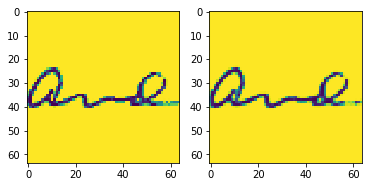

In [13]:
plt.figure(1)
plt.subplot(121)
plt.imshow(x_test[100].reshape(64,64))
plt.subplot(122)
plt.imshow(pred[100].reshape(64,64))

plt.show()

In [14]:
latent_variables = encoded.eval({inputs_:x_test},session=sess)
wd = dict(zip(names_test, latent_variables))
df = pd.DataFrame.from_dict(wd, orient="index")
df.to_csv("test_latent.csv")